In [1]:
## install 필요
# !pip install -q -U tensorflow-text --quiet
# !pip install -q tf-models-official

In [1]:
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import datetime
from collections import Counter
import pickle
import datetime
import time
import re
import random

In [2]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

# book_review로 긍부정_dataset 만들기

In [4]:
book = pd.read_parquet('files/book_user_14_20.parquet', engine='pyarrow')

### 평점을 1~5점까지 다양하게 준 사람을 훈련 데이터로 (평점을 전부 5점으로만 준 사람의 리뷰 데이터는 신뢰도 떨어짐)

In [5]:
def overall_count(a):
    return a.overall.nunique()

In [6]:
user_overall_nunique = book.groupby('reviewerID').apply(overall_count)

In [7]:
uon_vc = pd.DataFrame(user_overall_nunique)[0].value_counts()

In [8]:
overall_5_users = list(user_overall_nunique[user_overall_nunique==5].index)

In [9]:
new_book = book[book.reviewerID.isin(overall_5_users)]

### 5점 준게 많아서 5점을 긍정으로, 1,2점을 부정으로

In [10]:
neg_reviews = list(new_book[new_book.overall.isin([1,2])].reviewText)
neg_reviews = list(set(neg_reviews))
neg_reviews = [i for i in neg_reviews if i != None]

In [11]:
pos_reviews = list(new_book[new_book.overall==5].reviewText)
pos_reviews = list(set(pos_reviews))
pos_reviews = [i for i in pos_reviews if i != None]

In [12]:
print(len(pos_reviews))
print(len(neg_reviews))

279756
86157


## 긍부정 비율 맞추기

In [13]:
pos_reviews2 = []
random_ind_list = [i for i in range(len(pos_reviews))]
pop_ind_list = random.sample(random_ind_list, len(pos_reviews)//3)
for ind in pop_ind_list:
    pos_reviews2.append(pos_reviews[ind])

In [14]:
len(pos_reviews2)

93252

### train, test - random으로 split

In [20]:
test_pos_reviews = []
random_ind_list = [i for i in range(len(pos_reviews2))]
pop_ind_list = random.sample(random_ind_list, len(pos_reviews2)//5)
for ind in pop_ind_list:
    test_pos_reviews.append(pos_reviews2[ind])
train_pos_reviews = list(set(pos_reviews2) - set(test_pos_reviews))

In [21]:
test_neg_reviews = []
random_ind_list = [i for i in range(len(neg_reviews))]
pop_ind_list = random.sample(random_ind_list, len(neg_reviews)//5)
for ind in pop_ind_list:
    test_neg_reviews.append(neg_reviews[ind])
train_neg_reviews = list(set(neg_reviews) - set(test_neg_reviews))

In [22]:
# train_pos_reviews = []
# test_pos_reviews = []
# random_ind_list = [i for i in range(len(pos_reviews))]
# pop_ind_list = random.sample(random_ind_list, len(pos_reviews)//5)
# for ind in tqdm(range(len(pos_reviews))):
#     if ind in pop_ind_list:
#         test_pos_reviews.append(pos_reviews[ind])
#     else:
#         train_pos_reviews.append(pos_reviews[ind])

In [23]:
# train_neg_reviews = []
# test_neg_reviews = []
# random_ind_list = [i for i in range(len(neg_reviews))]
# pop_ind_list = random.sample(random_ind_list, len(neg_reviews)//5)
# for ind in tqdm(range(len(neg_reviews))):
#     if ind in pop_ind_list:
#         test_neg_reviews.append(neg_reviews[ind])
#     else:
#         train_neg_reviews.append(neg_reviews[ind])

In [24]:
print(len(train_pos_reviews))
print(len(test_pos_reviews))
print(len(train_neg_reviews))
print(len(test_neg_reviews))

74602
18650
68926
17231


In [25]:
for n,r in enumerate(train_pos_reviews):
    f = open(f"book_review2/train/pos/{n}.txt", 'w')
    f.write(r)
    f.close()
for n,r in enumerate(test_pos_reviews):
    f = open(f"book_review2/test/pos/{n}.txt", 'w')
    f.write(r)
    f.close()
for n,r in enumerate(train_neg_reviews):
    f = open(f"book_review2/train/neg/{n}.txt", 'w')
    f.write(r)
    f.close()
for n,r in enumerate(test_neg_reviews):
    f = open(f"book_review2/test/neg/{n}.txt", 'w')
    f.write(r)
    f.close()

# code

In [26]:
dataset_dir = 'book_review2'
train_dir = os.path.join(dataset_dir,'train')

In [27]:
# hidden folder 생기는 경우 있어서 제거해줌 - hidden folder 있으면 class에 포함됨
if '.ipynb_checkpoints' in os.listdir("book_review2/train"):
    shutil.rmtree("book_review2/train/.ipynb_checkpoints")
if '.ipynb_checkpoints' in os.listdir("book_review2/test"):
    shutil.rmtree("book_review2/test/.ipynb_checkpoints")

In [30]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'book_review2/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'book_review2/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'book_review2/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 143528 files belonging to 2 classes.
Using 114823 files for training.
Found 143528 files belonging to 2 classes.
Using 28705 files for validation.
Found 35881 files belonging to 2 classes.


In [31]:
class_names

['neg', 'pos']

In [32]:
for text_batch, label_batch in train_ds.take(1):
    for i in range(2):
        print(f'Review: {text_batch.numpy()[i]}')
        label = label_batch.numpy()[i]
        print(f'Label : {label} ({class_names[label]})')

Review: b"I love this series and this one certainly didn't disappoint. So many laugh out loud moments. Please let the next book be 1st quarter 2017.  So many things left unanswered. Hoping next book moves story lines forward and answer some long standing questions.."
Label : 1 (pos)
Review: b'Im not one for motorcycle club books but this one very entertaining and well written with a great story. It proves the theme of bad things happen to good people and although a somewhat happy ending there are still some unfinished parts of this story that I hope get brought up in future books.'
Label : 1 (pos)


In [33]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-2_H-128_A-2'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]
# bert_model_name = 'electra_base'
map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [34]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [35]:
# text_test = ['this is such an amazing movie!. I hate the movie', 'hello world']
# text_preprocessed = bert_preprocess_model(text_test)

# print(f'Keys       : {list(text_preprocessed.keys())}')
# print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
# print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
# print(f'Input Mask : {text_preprocessed["input_mask"]}')
# print(f'Type Ids   : {text_preprocessed["input_type_ids"]}')

In [36]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [37]:
# bert_results = bert_model(text_preprocessed)

# print(f'Loaded BERT: {tfhub_handle_encoder}')
# print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
# print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
# print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
# print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

In [38]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [39]:
classifier_model = build_classifier_model()
# bert_raw_result = classifier_model(tf.constant(text_test))
# print(tf.sigmoid(bert_raw_result))

In [40]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [41]:
epochs = 6
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [42]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [43]:
len(train_ds)

3589

In [44]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Epoch 1/6
3589/3589 [==============================] - 720s 199ms/step - loss: 0.4340 - binary_accuracy: 0.7776 - val_loss: 0.2657 - val_binary_accuracy: 0.8883
Epoch 2/6
3589/3589 [==============================] - 713s 199ms/step - loss: 0.2731 - binary_accuracy: 0.8844 - val_loss: 0.2363 - val_binary_accuracy: 0.9030
Epoch 3/6
3589/3589 [==============================] - 713s 199ms/step - loss: 0.2400 - binary_accuracy: 0.9003 - val_loss: 0.2275 - val_binary_accuracy: 0.9069
Epoch 4/6
3589/3589 [==============================] - 712s 198ms/step - loss: 0.2209 - binary_accuracy: 0.9095 - val_loss: 0.2272 - val_binary_accuracy: 0.9119
Epoch 5/6
3589/3589 [==============================] - 712s 198ms/step - loss: 0.2087 - binary_accuracy: 0.9162 - val_loss: 0.2257 - val_binary_accuracy: 0.9132
Epoch 6/6
3589/3589 [==============================] - 711s 198ms/step - loss: 0.2018 - binary_accuracy

# test 정확도

In [45]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

1122/1122 [==============================] - 68s 61ms/step - loss: 0.2300 - binary_accuracy: 0.9108
Loss: 0.2300180345773697
Accuracy: 0.9108163118362427


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


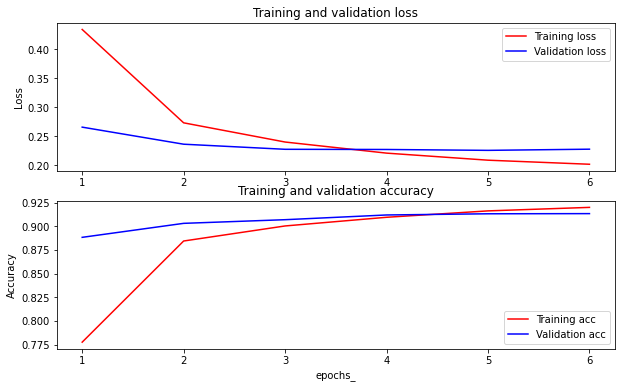

In [46]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs_ = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs_, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs_, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('epochs_')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs_, acc, 'r', label='Training acc')
plt.plot(epochs_, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('epochs_')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [47]:
dataset_name = 'book2'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

In [48]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [49]:
def print_my_examples(inputs, results):
    result_for_printing = \
      [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                           for i in range(len(inputs))]
    print(*result_for_printing, sep='\n')
    print()


examples = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...',
    "Most certainly one of the most heart warming books I've had the pleasure of reading in a long time ! Thoroughly enjoyed it ! And would ask anyone getting the chance to read ,please do"
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input: this is such an amazing movie! : score: 0.996751
input: The movie was great!           : score: 0.988928
input: The movie was meh.             : score: 0.099834
input: The movie was okish.           : score: 0.005389
input: The movie was terrible...      : score: 0.005237
input: Most certainly one of the most heart warming books I've had the pleasure of reading in a long time ! Thoroughly enjoyed it ! And would ask anyone getting the chance to read ,please do : score: 0.994345

Results from the model in memory:
input: this is such an amazing movie! : score: 0.996751
input: The movie was great!           : score: 0.988928
input: The movie was meh.             : score: 0.099834
input: The movie was okish.           : score: 0.005389
input: The movie was terrible...      : score: 0.005237
input: Most certainly one of the most heart warming books I've had the pleasure of reading in a long time ! Thoroughly enjoyed it ! And would ask anyone getting the c

In [50]:
serving_results = reloaded_model \
            .signatures['serving_default'](tf.constant(examples))

serving_results = tf.sigmoid(serving_results['classifier'])

print_my_examples(examples, serving_results)

input: this is such an amazing movie! : score: 0.996751
input: The movie was great!           : score: 0.988928
input: The movie was meh.             : score: 0.099834
input: The movie was okish.           : score: 0.005389
input: The movie was terrible...      : score: 0.005237
input: Most certainly one of the most heart warming books I've had the pleasure of reading in a long time ! Thoroughly enjoyed it ! And would ask anyone getting the chance to read ,please do : score: 0.994345



# 리뷰 긍부정 점수 컬럼 생성

In [3]:
df = pd.read_parquet('merge_book_2015_30_5.parquet', engine='pyarrow')

In [5]:
reloaded_model = tf.saved_model.load('book_bert')

In [6]:
df_reviews = []
for i in df.reviewText:
    if i != None:
        df_reviews.append(i)

In [7]:
len(df_reviews)

823236

In [8]:
# review_sentiment_scores = tf.sigmoid(reloaded_model(tf.constant(df_reviews)))

### 기존 컬럼에 모델 적용

In [9]:
# 한번에 하면 메모리 에러 나서 100개씩 진행
review_score_list = []
for i in tqdm(range(len(df_reviews)//100+1)):
    for j in reloaded_model(tf.constant(df_reviews[i*100:i*100+100])):
        review_score_list.append(float(j))

100%|██████████| 8233/8233 [23:42<00:00,  5.79it/s]


In [10]:
len(review_score_list)

823236

In [11]:
review_score_list = tf.sigmoid(review_score_list)

In [19]:
review_score_list_float = []
for i in tqdm(review_score_list):
    review_score_list_float.append(float(i))

100%|██████████| 823236/823236 [02:05<00:00, 6555.92it/s]


In [21]:
total_review_score_list = review_score_list_float.copy()

In [22]:
# review가 none 값 들어있는 index에 감성점수도 none값 넣어줌
none_review_index = list(df[pd.isnull(df.reviewText)].index)

In [23]:
for i in none_review_index:
    total_review_score_list.insert(i,None)

In [24]:
df['review_sentiment_score'] = total_review_score_list

In [27]:
df.to_parquet('merge_book_sentiment_2015_30_5.parquet', engine='pyarrow', index=False)